In [1]:
# Model Training - Boston Housing Price Prediction
# Loads dataset.csv, performs EDA, trains models, and saves model.pkl

import os
import json
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Paths
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_PATH = os.path.join(PROJECT_ROOT, "data", "boston_house_prices_dataset.csv")

MODEL_PATH = os.path.join(PROJECT_ROOT, "model.pkl")

# Load data
df = pd.read_csv(DATA_PATH)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,5.33,36.2


In [7]:
# EDA
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CRIM,506.0,3.613524,8.601545,0.00632,0.082045,0.25651,3.677083,88.9762
ZN,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
INDUS,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
CHAS,506.0,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
NOX,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
RM,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
AGE,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
DIS,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
RAD,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000
TAX,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000


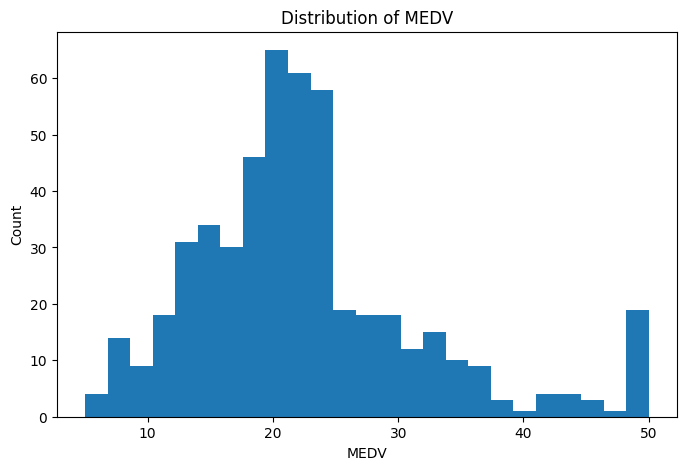

In [8]:
# Histogram of target variable (MEDV)
plt.figure(figsize=(8, 5))
plt.hist(df['MEDV'], bins=25)
plt.xlabel('MEDV')
plt.ylabel('Count')
plt.title('Distribution of MEDV')
plt.show()

In [9]:
# Train models
X = df.drop('MEDV', axis=1)
y = df['MEDV']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

pipe_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42))
])

def cv_rmse(pipe):
    scores = cross_val_score(
        pipe, X_train, y_train,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=1
    )
    return np.sqrt(-scores).mean()

print('LR CV RMSE:', cv_rmse(pipe_lr))
print('RF CV RMSE:', cv_rmse(pipe_rf))

LR CV RMSE: 4.912328998897041
RF CV RMSE: 3.814606708193678


In [12]:
# Grid search for RandomForest
param_grid = {
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [None, 6, 12]
}

grid = GridSearchCV(
    pipe_rf,
    param_grid,
    cv=4,
    scoring='neg_mean_squared_error',
    n_jobs=1
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_
print('Best params:', grid.best_params_)

# Evaluate on test set
preds = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)
print('Test RMSE:', rmse, 'R2:', r2)

Best params: {'rf__max_depth': None, 'rf__n_estimators': 100}
Test RMSE: 2.8299022899365696 R2: 0.8907959384410822
